# Generative Adversial Network

The dataset does not represent the non-churn class enough.

A GAN model is used to address this class imbalance problem by generating synthetic data for the minority non-churn class.

The objective is to augment the existing dataset with the synthetic data generated by the GAN.

### Importing data libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

### Importing the Conditional GAN model

In [ ]:
from ctgan import CTGAN

### Importing the ENN undersampling strategy

Edited Nearest Neighbor (ENN) is an undersampling method technique that remove the majority class to match the minority class. 

ENN works by removing samples whose class label differs from the class of the majority of their k nearest neighbors.

This helps to enhance the GAN generated dataset

In [7]:
from imblearn.under_sampling import EditedNearestNeighbours

### Reading dataset into a dataframe

In [4]:
df = pd.read_csv('ecom-user-churn-data.csv')

In [6]:
df

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,ses_rec_cv,user_rec,ses_n,ses_n_r,int_n,int_n_r,...,int_cat16_n,int_cat17_n,int_cat18_n,int_cat19_n,int_cat20_n,int_cat21_n,int_cat22_n,int_cat23_n,int_cat24_n,target_class
0,89,23.0,16.000000,0.000000,0.000000,39.0,2.0,0.051282,3.0,1.500000,...,0,0,0,0,3,0,0,0,0,1
1,251,23.0,61.000000,0.000000,0.000000,85.0,2.0,0.023529,2.0,1.000000,...,0,0,0,0,0,0,1,0,0,1
2,270,14.0,0.100000,0.300000,3.000000,21.0,11.0,0.523810,13.0,1.181818,...,0,0,0,0,0,0,13,0,0,1
3,298,11.0,13.000000,0.000000,0.000000,24.0,2.0,0.083333,4.0,2.000000,...,0,0,0,3,1,0,0,0,0,1
4,474,16.0,26.000000,0.000000,0.000000,43.0,2.0,0.046512,2.0,1.000000,...,2,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49353,1406824,14.0,73.000000,0.000000,0.000000,87.0,2.0,0.022989,2.0,1.000000,...,0,0,0,2,0,0,0,0,0,1
49354,1406906,19.0,13.000000,0.000000,0.000000,32.0,2.0,0.062500,4.0,2.000000,...,0,2,0,0,0,0,0,2,0,1
49355,1406914,21.0,0.666667,0.942809,1.414214,23.0,4.0,0.173913,14.0,3.500000,...,0,0,0,14,0,0,0,0,0,1
49356,1407221,1.0,0.000000,0.000000,-1.000000,2.0,2.0,1.000000,2.0,1.000000,...,0,2,0,0,0,0,0,0,0,1


### Feature Reduction

Some of the columns in the dataset are redundant data and irrelevant for churn.

These columns are dropped.

In [19]:
columns_to_remove = df.columns[df.columns.str.startswith('int_cat') | df.columns.str.endswith('_n')]
df = df.drop(columns=columns_to_remove)

In [20]:
df = df.drop(columns=['ses_n_r', 'ses_rec_cv', 'rev_sum', 'time_to_tran'])

In [21]:
df.head()

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,user_rec,int_n_r,tran_n_r,rev_sum_r,major_spend_r,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,target_class
0,89,23.0,16.0,0.0,39.0,1.500000,0.0,0.0,0.0,1.5,7.000000,0.000000,11.000000,7.071068,0.500000,2.866667,1.911111,1
1,251,23.0,61.0,0.0,85.0,1.000000,0.0,0.0,0.0,1.0,6.000000,1.414214,13.500000,2.121320,1.000000,0.000000,0.000000,1
2,270,14.0,0.1,0.3,21.0,1.181818,0.0,0.0,0.0,1.0,7.454546,0.522233,12.636364,4.342182,0.363636,1.104545,0.934615,1
3,298,11.0,13.0,0.0,24.0,2.000000,0.0,0.0,0.0,1.5,7.500000,0.707107,11.500000,4.949748,0.000000,0.508333,0.254167,1
4,474,16.0,26.0,0.0,43.0,1.000000,0.0,0.0,0.0,1.0,7.000000,0.000000,19.500000,2.121320,0.500000,0.000000,0.000000,1


### Visualizing the class imbalance

In [22]:
def create_pi_chart(df):
    value_counts = df['target_class'].value_counts()
    plt.figure(figsize=(10, 8))
    plt.pie(
        value_counts,
        labels=[f'Churn (1): {value_counts[1]} rows', f'Not churn (0): {value_counts[0]} rows'],
        autopct='%1.1f%%', 
        startangle=140
    )
    plt.title('Distribution of Ratings')
    plt.show()

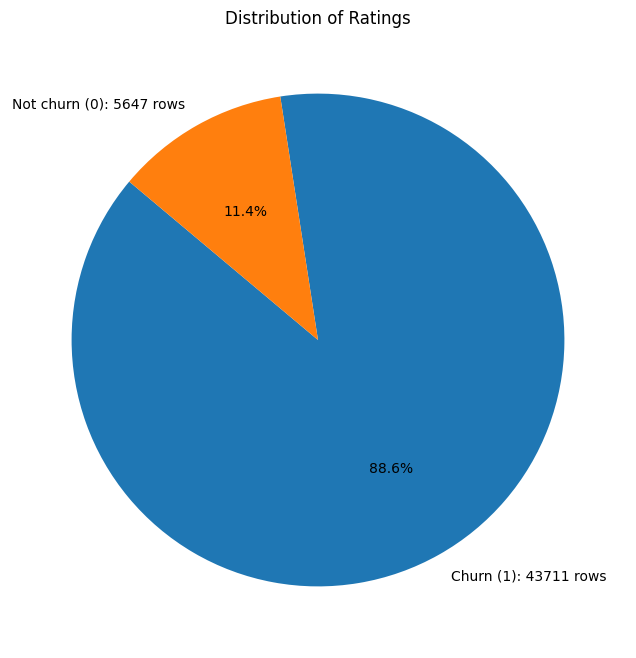

In [23]:
create_pi_chart(df)

From the above chart it is evident that the dataset has a class imbalance problem

#### Function to generate data by learning the underlying patterns

In [24]:
def get_synthetic_data(min_class, n_generated_data):
    batch_size = 5000
    epochs = 300

    model = CTGAN(
        batch_size=batch_size,
        epochs=epochs, 
        verbose=True
    )
    model.fit(min_class)
    generated_df = model.sample(n_generated_data)
    generated_df = abs(generated_df)
    generated_df['ses_rec'] = round(generated_df['ses_rec'])
    generated_df['user_rec'] = round(generated_df['user_rec'])
    return generated_df

#### Function to add the generated synthetic data to the original dataset

In [11]:
def add_to_dataset(df, generated_df, target_label):
    data= pd.concat([df, generated_df])
    enn = EditedNearestNeighbours(n_neighbors=3)
    X = data.drop([target_label],axis=1)
    y = data[target_label]
    X, y = enn.fit_resample(X, y)
    final_df = pd.concat([X, y], axis=1)
    return final_df

### Generating the synthetic data

Initializing the minority and majority class

In [9]:
min_class = df.loc[df['target_class'] == 0]
maj_class = df.loc[df['target_class'] == 1]

Assigning the no. of data samples the GAN will generate

In [10]:
n_synthetic_samples = (maj_class.shape[0] - min_class.shape[0])*2

In [26]:
fake_df = get_synthetic_data(min_class, n_synthetic_samples)

Gen. (-1.42) | Discrim. (0.08): 100%|██████████| 200/200 [01:01<00:00,  3.24it/s] 


In [27]:
fake_df

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,user_rec,int_n_r,tran_n_r,rev_sum_r,major_spend_r,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,target_class
0,1152109,2.0,2.808309,0.303825,37.0,1.423893,0.002861,354.386291,0.002003,0.956618,5.024047,1.897745,11.761246,3.143542,0.865847,1.151027,3.962905,0
1,684731,11.0,5.794603,32.974851,10.0,1.022041,0.000032,365.597998,0.000057,0.987315,6.148604,1.206300,13.845275,1.982799,0.001845,0.121173,0.629383,0
2,250742,8.0,1.040759,3.372104,16.0,1.167603,0.001476,24.501918,0.001156,1.030816,6.443661,1.264422,8.919711,6.634316,0.005537,3.554561,0.061207,0
3,1117914,24.0,0.612832,0.043653,56.0,1.777210,0.000043,395.582624,0.003164,0.984362,6.985054,1.207553,12.265226,3.316878,0.001925,0.429109,0.453381,0
4,165854,2.0,0.413118,9.948551,74.0,1.035187,0.003400,669.194331,0.002479,3.038906,8.000422,0.764554,9.959177,4.274640,0.007008,0.055644,1.171897,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76123,541058,6.0,9.305234,0.392036,6.0,0.954960,0.001109,623.811191,0.000648,0.924706,7.516031,0.016448,22.086478,7.753293,0.011879,0.001202,1.400466,0
76124,354443,13.0,10.550356,11.058111,17.0,6.455087,0.000411,594.147143,0.000830,0.996744,6.006957,0.635004,14.151279,2.932882,0.015915,0.023991,2.674442,0
76125,1045707,3.0,28.607923,0.395115,23.0,3.298709,0.004350,653.162701,0.003722,0.982278,7.003049,0.602243,11.384530,4.278870,0.023994,19.989582,1.894292,0
76126,177746,12.0,77.174864,3.730670,20.0,1.303747,0.000154,34.015781,0.001181,2.328802,6.986423,0.606622,12.770524,6.253293,1.048417,37.058269,0.050185,0


### Augmenting the original dataset

In [28]:
augmented_df = add_to_dataset(df, fake_df, 'target_class')

In [29]:
augmented_df.to_csv('augmented-ecom-churn-data.csv', encoding='utf-8')

In [30]:
augmented_df

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,user_rec,int_n_r,tran_n_r,rev_sum_r,major_spend_r,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,target_class
0,64931,2.0,2.000000,3.807887,98.0,4.00,0.121951,4423.9023,0.024390,2.487805,5.853659,1.062096,15.292683,4.290943,0.390244,7.451220,1.862805,0
1,500130,12.0,6.000000,6.164414,36.0,5.60,0.800000,17160.0000,0.200000,4.400000,7.400000,0.547723,12.400000,8.848729,0.600000,3.943333,0.704167,0
2,638708,9.0,2.000000,2.828427,15.0,1.25,0.000000,0.0000,0.000000,1.000000,8.000000,0.000000,9.500000,7.505554,1.000000,3.212500,2.570000,0
3,669949,26.0,0.000000,0.000000,27.0,13.00,1.000000,44672.0000,0.333333,4.666666,7.000000,0.000000,19.333334,0.577350,0.000000,27.733334,2.133333,0
4,680488,13.0,1.555556,2.948111,32.0,2.40,0.100000,1296.0000,0.100000,2.200000,7.100000,0.316228,16.000000,3.741658,0.300000,3.900000,1.625000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106645,1406824,14.0,73.000000,0.000000,87.0,1.00,0.000000,0.0000,0.000000,1.000000,6.500000,2.121320,10.500000,2.121320,0.000000,0.000000,0.000000,1
106646,1406906,19.0,13.000000,0.000000,32.0,2.00,0.000000,0.0000,0.000000,1.500000,7.000000,0.000000,12.000000,5.656854,0.000000,4.016667,2.008333,1
106647,1406914,21.0,0.666667,0.942809,23.0,3.50,0.000000,0.0000,0.000000,3.000000,7.000000,0.000000,13.250000,2.629955,0.750000,6.362500,1.817857,1
106648,1407221,1.0,0.000000,0.000000,2.0,1.00,0.000000,0.0000,0.000000,1.000000,8.000000,0.000000,14.500000,7.778174,1.000000,0.000000,0.000000,1


### Visualizing the class imbalance for the augmented dataset

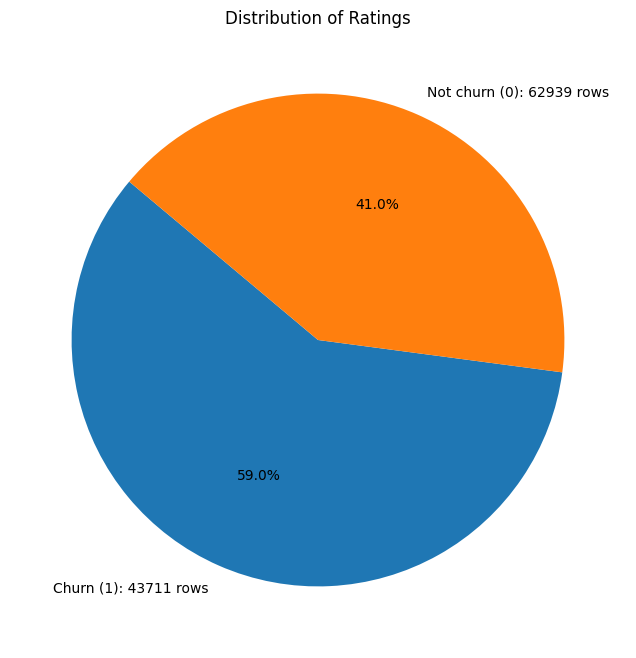

In [31]:
create_pi_chart(augmented_df)

In [32]:
augmented_df.shape

(106650, 18)